In [1]:
import pandas as pd

# Load the data
data = pd.read_csv ('H1.csv')

# Select relevant columns
columns_to_use = ['Calcination Time (min)', 'Calcination Temp (C)', 'Reaction Temp (C)', 'Reaction Time (min)', 'Biodiesel Yield (%)']
data = data[columns_to_use]

# Display the first few rows
print(data.head())


   Calcination Time (min)  Calcination Temp (C)  Reaction Temp (C)  \
0                     120                   500                 55   
1                     240                   500                 55   
2                     120                   700                 55   
3                     240                   700                 55   
4                     120                   500                 65   

   Reaction Time (min)  Biodiesel Yield (%)  
0                   60                70.54  
1                   80                74.22  
2                   80                78.67  
3                   60                68.13  
4                   80                68.80  


In [2]:
# Bounds for variables
bounds = {
    'Calcination Time (min)': (120, 240),   # Example bounds
    'Calcination Temp (C)': (500, 700),
    'Reaction Temp (C)': (55, 65),
    'Reaction Time (min)': (60, 80)
}

In [3]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

In [4]:
# Separate features and target
X = data.drop('Biodiesel Yield (%)', axis=1)
y = data['Biodiesel Yield (%)']

# Fit a regression model (e.g., Random Forest)
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

In [5]:
def evaluate(individual):
    # Prepare the input for prediction
    input_data = np.array(individual).reshape(1, -1)
    # Predict biodiesel yield
    predicted_yield = model.predict(input_data)
    return (predicted_yield[0],)  # Return as a tuple

In [6]:
from deap import base, tools

# Initialize toolbox
toolbox = base.Toolbox()

# Register functions with toolbox
toolbox.register("evaluate", evaluate)  # Assume `evaluate` is a function you have defined
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blending crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)  # Gaussian mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection


In [7]:
# Ensure mutated individuals stay within bounds
def checkBounds(mins, maxs):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] < mins[i]:
                        child[i] = mins[i]
                    elif child[i] > maxs[i]:
                        child[i] = maxs[i]
            return offspring
        return wrapper
    return decorator

# Extract bounds
mins = [bounds[key][0] for key in bounds]
maxs = [bounds[key][1] for key in bounds]

# Apply the decorator to the genetic operators
toolbox.decorate("mate", checkBounds(mins, maxs))
toolbox.decorate("mutate", checkBounds(mins, maxs))

gen	avg    	max   
0  	2.46082	6.3164
1  	3.00047	5.43475
2  	3.68304	6.66176
3  	4.56131	7.82214
4  	5.42063	10.1349
5  	6.86524	13.0662
6  	8.42181	13.7518
7  	10.4477	15.6919
8  	12.4204	16.314 
9  	14.1204	18.8131
10 	15.5358	23.566 
11 	16.8976	24.4086
12 	18.7732	29.4364
13 	20.9422	29.7518
14 	23.8905	30.7826
15 	26.9894	35.9784
16 	29.2684	38.2683
17 	32.2591	46.1172
18 	35.5096	47.233 
19 	39.0541	74.5238
20 	43.1748	77.8076
21 	49.0338	78.835 
22 	55.7312	95.7946
23 	66.0222	101.262
24 	79.281 	110.012
25 	90.4204	110.835
26 	99.3639	123.513
27 	108.096	133.953
28 	115.619	146.24 
29 	123.518	151.225
30 	131.06 	168.836
31 	138.125	168.836
32 	144.576	170.485
33 	152.029	184.683
34 	161.776	185.018
35 	170.307	194.47 
36 	179.584	203.568
37 	186.441	214.091
38 	193.258	228.087
39 	201.768	246.344
40 	211.142	247.554
41 	222.666	256.968
42 	231.421	256.968
43 	240.174	260.925
44 	247.189	268.032
45 	254.479	280.249
46 	261.364	292.264
47 	269.937	299.933
48 	279.41 	314.205
49

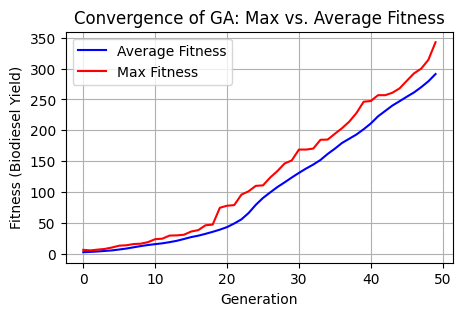

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Initialize the Genetic Algorithm components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    return sum(individual),  # Fitness function (simple example)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize the population and logbook
population = toolbox.population(n=100)
logbook = tools.Logbook()
logbook.header = ['gen', 'avg', 'max']

# Define statistics to log
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

# Genetic Algorithm settings
NGEN = 50  # Number of generations
CXPB, MUTPB = 0.7, 0.2  # Crossover and mutation probabilities

# Run the Genetic Algorithm
for gen in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the offspring with invalid fitnesses
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population with the new offspring
    population[:] = offspring

    # Record statistics for this generation
    record = stats.compile(population)
    logbook.record(gen=gen, **record)
    print(logbook.stream)

# After the GA, logbook contains the progress data
# Let's visualize the convergence

gen = logbook.select("gen")
avg = logbook.select("avg")
max_ = logbook.select("max")

# Plot the convergence of the algorithm
plt.figure(figsize=(5, 3))
plt.plot(gen, avg, label="Average Fitness", color="blue")
plt.plot(gen, max_, label="Max Fitness", color="red")
plt.xlabel("Generation")
plt.ylabel("Fitness (Biodiesel Yield)")
plt.title("Convergence of GA: Max vs. Average Fitness")
plt.legend()
plt.grid(True)
plt.show()

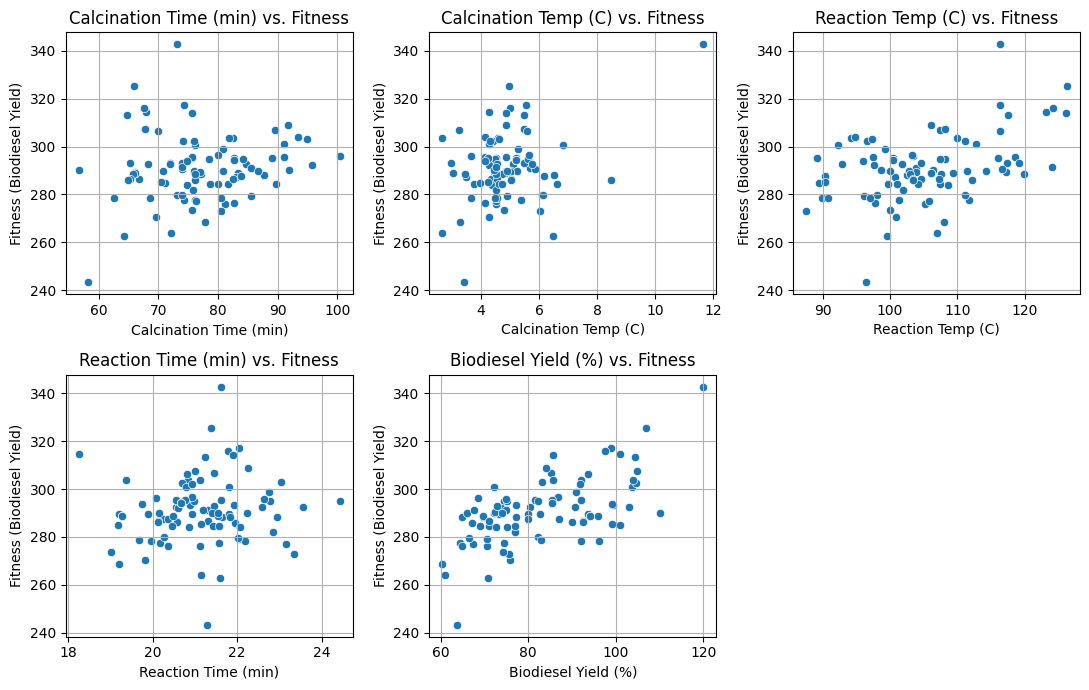

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Extracting the parameters and fitness values from the population
population_params = [ind for ind in population]
fitness_scores = [ind.fitness.values[0] for ind in population]

# Ensure the number of param_names matches the size of individuals
# Add the correct number of parameter names according to your GA's parameter count
param_names = ['Calcination Time (min)', 'Calcination Temp (C)', 'Reaction Temp (C)', 'Reaction Time (min)', 'Biodiesel Yield (%)']  # Add more if needed

# Convert to DataFrame for easy plotting
df_results = pd.DataFrame(population_params, columns=param_names)
df_results['fitness'] = fitness_scores

# Plot individual parameters vs. fitness
plt.figure(figsize=(11, 7))

for i, col in enumerate(param_names):
    plt.subplot(2, 3, i+1)  # Adjust to fit number of subplots based on param_names
    sns.scatterplot(x=df_results[col], y=df_results['fitness'])
    plt.title(f'{col} vs. Fitness')
    plt.xlabel(col)
    plt.ylabel('Fitness (Biodiesel Yield)')
    plt.grid(True)

plt.tight_layout()
plt.show()

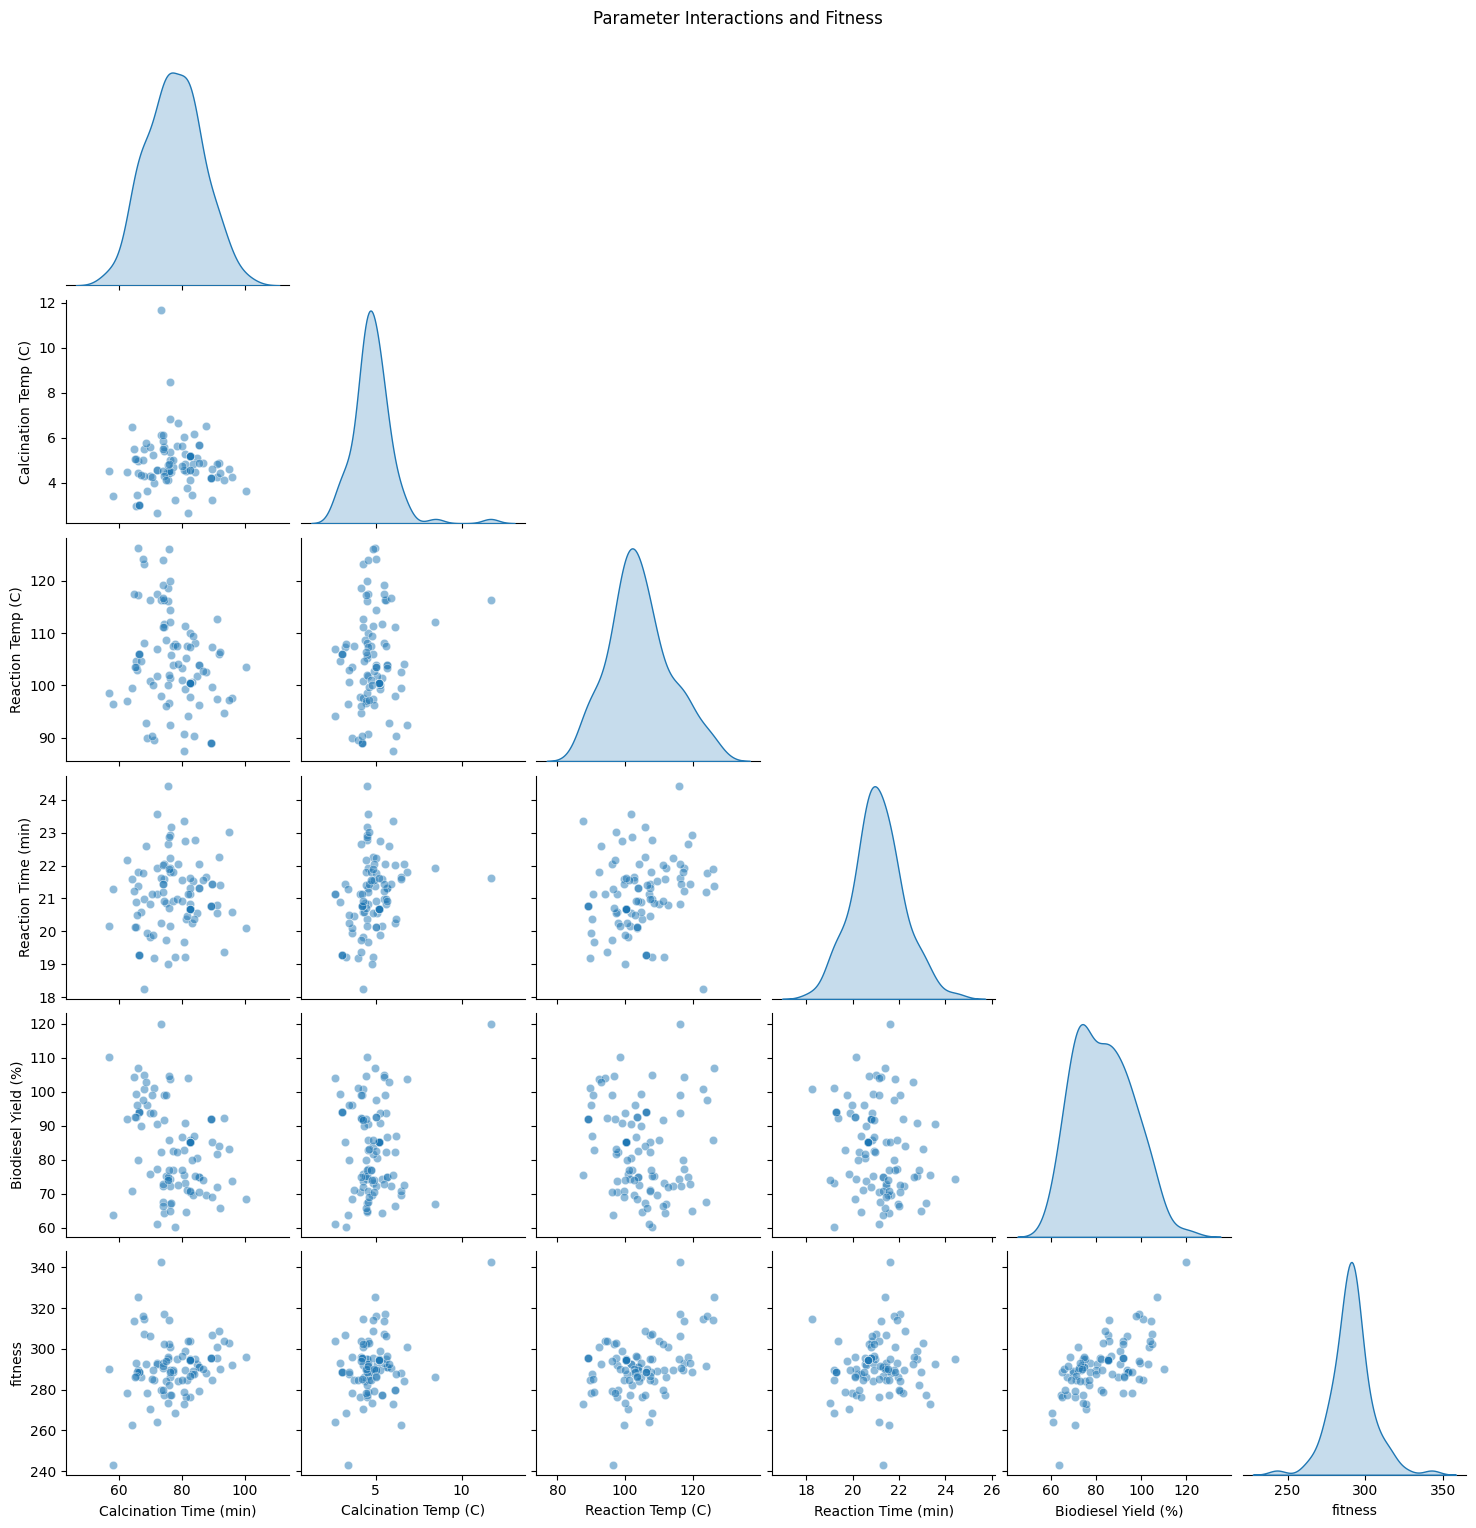

In [10]:
# Create a pair plot showing the relationships between parameters and fitness
sns.pairplot(df_results, diag_kind="kde", corner=True, plot_kws={'alpha': 0.5})
plt.suptitle("Parameter Interactions and Fitness", y=1.02)
plt.show()

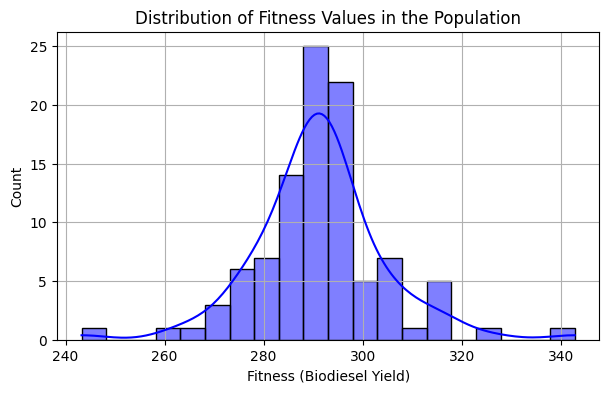

In [11]:
# Plot the distribution of fitness values
plt.figure(figsize=(7, 4))
sns.histplot(df_results['fitness'], kde=True, bins=20, color="blue")
plt.title("Distribution of Fitness Values in the Population")
plt.xlabel("Fitness (Biodiesel Yield)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

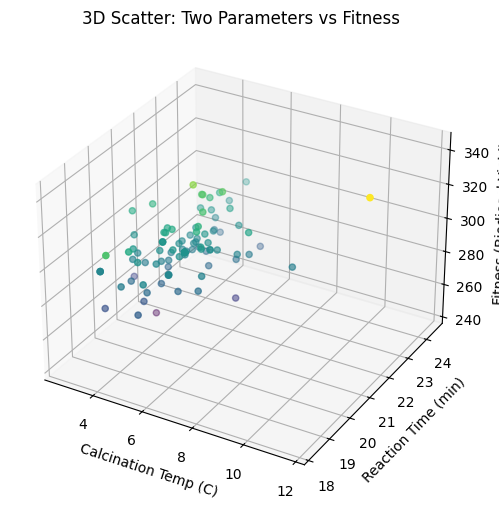

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Select two key parameters and fitness for 3D visualization
x_param = 'Calcination Temp (C)'
y_param = 'Reaction Time (min)'
z_fitness = 'fitness'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter(df_results[x_param], df_results[y_param], df_results[z_fitness], c=df_results[z_fitness], cmap='viridis')

# Label the axes
ax.set_xlabel(x_param)
ax.set_ylabel(y_param)
ax.set_zlabel('Fitness (Biodiesel Yield)')
plt.title("3D Scatter: Two Parameters vs Fitness")
plt.show()


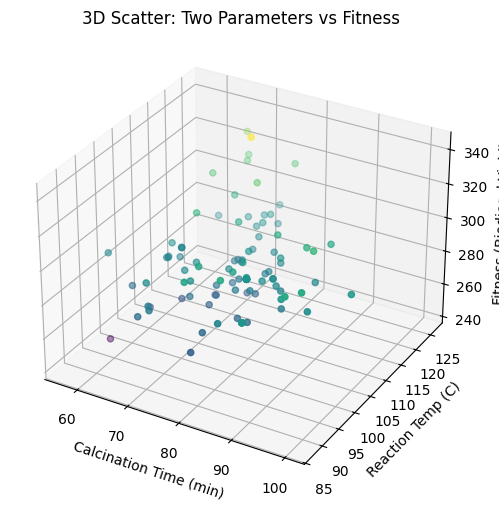

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Select two key parameters and fitness for 3D visualization
x_param = 'Calcination Time (min)'
y_param = 'Reaction Temp (C)'
z_fitness = 'fitness'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter(df_results[x_param], df_results[y_param], df_results[z_fitness], c=df_results[z_fitness], cmap='viridis')

# Label the axes
ax.set_xlabel(x_param)
ax.set_ylabel(y_param)
ax.set_zlabel('Fitness (Biodiesel Yield)')
plt.title("3D Scatter: Two Parameters vs Fitness")
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Load data (replace 'file_path' with your file location in Jupyter Notebook)
data = pd.read_csv("H1.csv")

# Display first few rows
data.head()

,Run,Calcination Time (min),Calcination Temp (C),Reaction Temp (C),Reaction Time (min),Biodiesel Yield (%),Validation,Residual (%)
0,1,120,500,55,60,70.54,Training,0.110
1,2,240,500,55,80,74.22,Training,0.073
2,3,120,700,55,80,78.67,Training,0.073
3,4,240,700,55,60,68.13,Training,0.036
4,5,120,500,65,80,68.80,Training,0.073


In [15]:
# Extract features and target from the dataset
features = data[['Calcination Time (min)', 'Calcination Temp (C)', 'Reaction Temp (C)', 'Reaction Time (min)']]
target = data['Biodiesel Yield (%)']

# Normalize features for GA compatibility
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Define fitness function for GA (maximize biodiesel yield)
def fitness(individual):
    Calcination_time, Calcination_temp, Rxn_time, Rxn_temp = individual
    scaled_input = np.array([[Calcination_time, Calcination_temp, Rxn_time, Rxn_temp]])
    
    # Scale back to original data to find yield prediction
    input_data = scaler.inverse_transform(scaled_input)
    
    # Find nearest actual biodiesel yield from dataset (or apply model if needed)
    nearest_index = np.argmin(np.sum(np.abs(features.values - input_data), axis=1))
    yield_value = target.values[nearest_index]
    
    return -yield_value  # Negate to maximize yield (GA minimizes by default)

In [16]:
# Set up bounds for GA based on feature scaling (0-1 after scaling)
bounds = [(0, 1) for _ in range(scaled_features.shape[1])]

# Run the differential evolution GA algorithm
result = differential_evolution(fitness, bounds, maxiter=100, popsize=15, mutation=(0.5, 1), recombination=0.7)

# Convert the best scaled result back to original feature values
optimized_values = scaler.inverse_transform([result.x])
print("Optimized Parameters:", optimized_values)
print("Maximized Biodiesel Yield:", -result.fun)

Optimized Parameters: [[127.09026741 689.18956905  60.16921063  72.38731494]]
Maximized Biodiesel Yield: 78.67


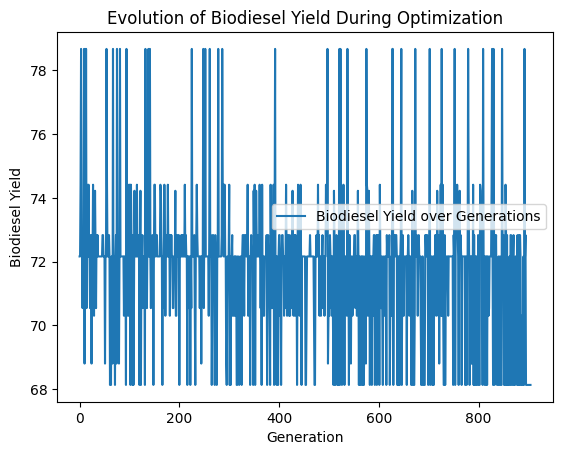

In [17]:
# Track history of yield values for visualization
yield_history = []

# Modify fitness function to log yield during each iteration
def fitness_log(individual):
    yield_value = -fitness(individual)
    yield_history.append(yield_value)
    return yield_value

# Re-run optimization with logging
result_with_log = differential_evolution(fitness_log, bounds, maxiter=100, popsize=15, mutation=(0.5, 1), recombination=0.7)

# Plot yield history
plt.plot(yield_history, label='Biodiesel Yield over Generations')
plt.xlabel('Generation')
plt.ylabel('Biodiesel Yield')
plt.title('Evolution of Biodiesel Yield During Optimization')
plt.legend()
plt.show()

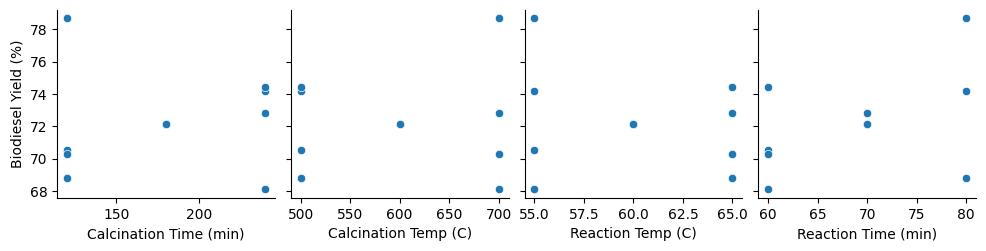

C:\Users\macbook\AppData\Local\Temp\ipykernel_13184\737467660.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


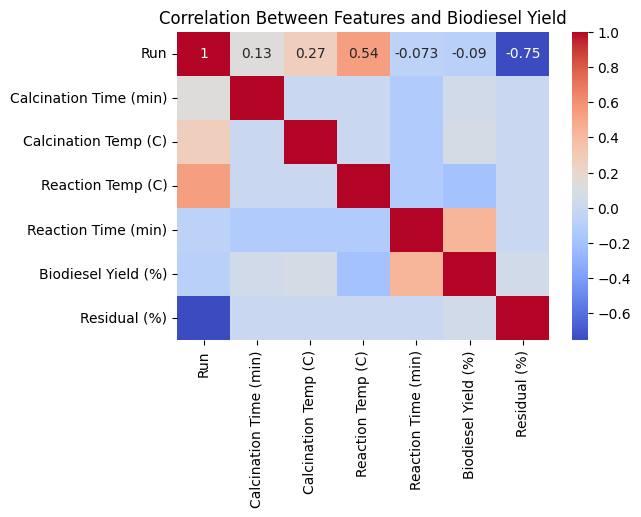

In [18]:
import seaborn as sns

# Pair plot to see relationships between variables and biodiesel yield
sns.pairplot(data, x_vars=['Calcination Time (min)', 'Calcination Temp (C)', 'Reaction Temp (C)', 'Reaction Time (min)'], y_vars='Biodiesel Yield (%)', kind='scatter')
plt.show()

# Heatmap of correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features and Biodiesel Yield')
plt.show()

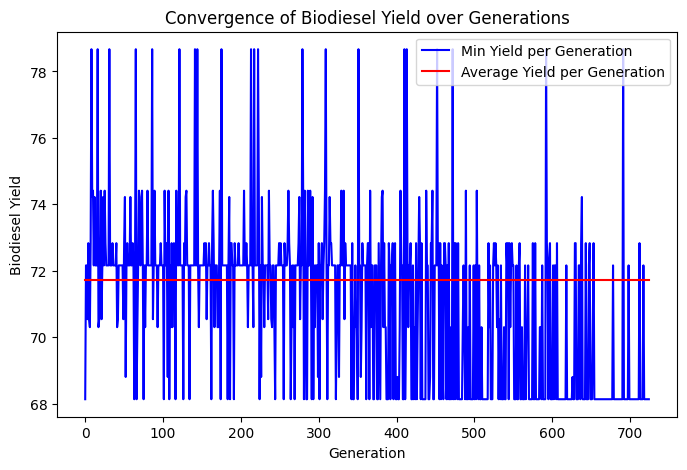

In [19]:
# Convergence plot to show minimum and average yields over generations
min_yield_per_gen = []
avg_yield_per_gen = []

# Modify fitness function to log yields during each generation
def fitness_track_convergence(individual):
    yield_value = -fitness(individual)
    min_yield_per_gen.append(yield_value)
    avg_yield_per_gen.append(np.mean(yield_history))
    return yield_value

# Re-run optimization with logging
result_convergence = differential_evolution(fitness_track_convergence, bounds, maxiter=100, popsize=15, mutation=(0.5, 1), recombination=0.7)

# Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(min_yield_per_gen, label='Min Yield per Generation', color='blue')
plt.plot(avg_yield_per_gen, label='Average Yield per Generation', color='red')
plt.xlabel('Generation')
plt.ylabel('Biodiesel Yield')
plt.title('Convergence of Biodiesel Yield over Generations')
plt.legend()
plt.show()

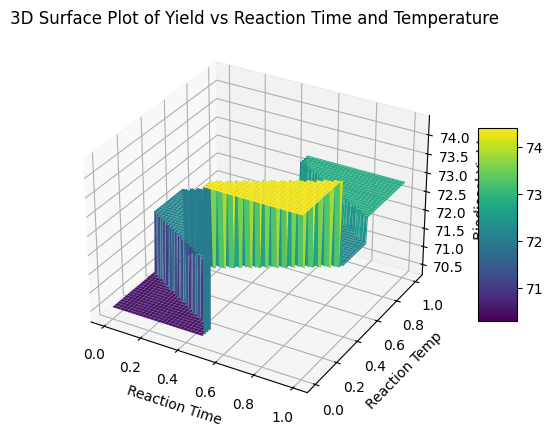

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Choose two variables (e.g., rxn time and rxn temp) and fix others to mean values
rxn_time_range = np.linspace(scaled_features[:, 0].min(), scaled_features[:, 0].max(), 100)
rxn_temp_range = np.linspace(scaled_features[:, 1].min(), scaled_features[:, 1].max(), 100)

# Create meshgrid
X, Y = np.meshgrid(rxn_time_range, rxn_temp_range)
Z = np.array([fitness([x, y, np.mean(scaled_features[:, 2]), np.mean(scaled_features[:, 3])]) for x, y in zip(X.ravel(), Y.ravel())])

# Reshape to match meshgrid dimensions
Z = Z.reshape(X.shape)

# Plot
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, -Z, cmap=cm.viridis, edgecolor='none')
ax.set_xlabel('Reaction Time')
ax.set_ylabel('Reaction Temp')
ax.set_zlabel('Biodiesel Yield')
ax.set_title('3D Surface Plot of Yield vs Reaction Time and Temperature')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

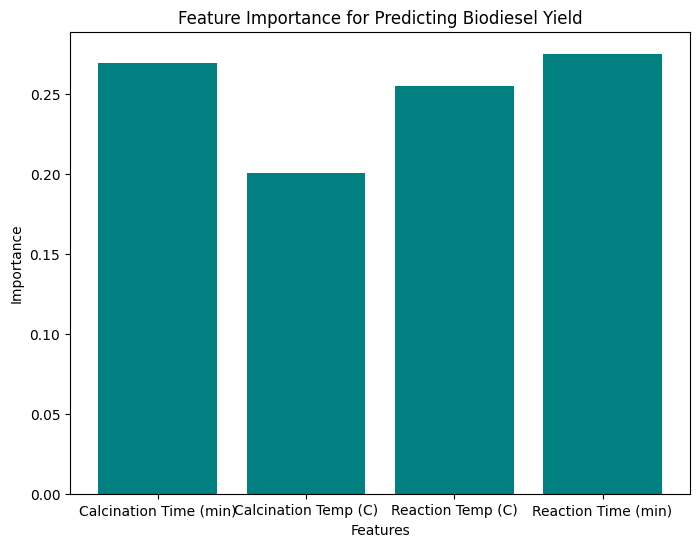

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Train a model to predict biodiesel yield and get feature importances
model = RandomForestRegressor()
model.fit(scaled_features, target)
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(features.columns, importances, color='teal')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for Predicting Biodiesel Yield')
plt.show()

Statistics for each factor:

                              Mean     Variance  Standard Deviation    Min  \
Calcination Time (min)  180.000000  2880.000000           53.665631  120.0   
Calcination Temp (C)    600.000000  8000.000000           89.442719  500.0   
Reaction Temp (C)        60.000000    20.000000            4.472136   55.0   
Reaction Time (min)      69.090909    69.090909            8.312094   60.0   

                          Max  Log (Mean)  
Calcination Time (min)  240.0    5.192957  
Calcination Temp (C)    700.0    6.396930  
Reaction Temp (C)        65.0    4.094345  
Reaction Time (min)      80.0    4.235423  


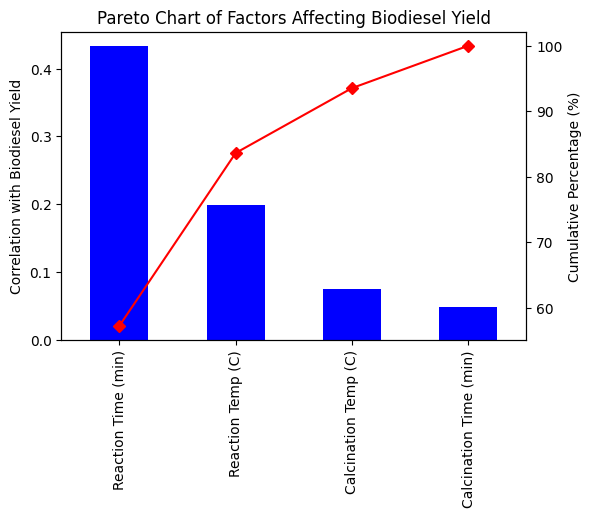

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('H1.csv')

# Drop 'Run' and 'Residual (%)' columns
df = data.drop(columns=['Run', 'Residual (%)', 'Validation'], errors='ignore')

# Calculate correlations of each factor with biodiesel yield
correlations = df.corr()["Biodiesel Yield (%)"].drop("Biodiesel Yield (%)").abs()

# Sort correlations for Pareto chart
sorted_correlations = correlations.sort_values(ascending=False)

# Plot Pareto chart
fig, ax1 = plt.subplots(figsize=(6, 4))

# Bar plot for the factors
sorted_correlations.plot(kind="bar", color="blue", ax=ax1)
ax1.set_ylabel("Correlation with Biodiesel Yield")
ax1.set_title("Pareto Chart of Factors Affecting Biodiesel Yield")

# Cumulative percentage line plot
ax2 = ax1.twinx()
cumulative_percentage = sorted_correlations.cumsum() / sorted_correlations.sum() * 100
cumulative_percentage.plot(color="red", marker="D", ax=ax2)
ax2.set_ylabel("Cumulative Percentage (%)")

# Function to calculate statistics
def calculate_statistics(df):
    stats = pd.DataFrame({
        "Mean": df.mean(),
        "Variance": df.var(),
        "Standard Deviation": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Log (Mean)": np.log(df.mean().replace(0, np.nan))  # Avoid log(0) by replacing 0 with NaN
    }).drop("Biodiesel Yield (%)", errors='ignore')  # Exclude target variable from stats if needed
    return stats

# Calculate statistics for each factor
statistics = calculate_statistics(df)

# Display the statistics
print("Statistics for each factor:\n")
print(statistics)

# Show plot
plt.show()
